In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [2]:
def calibrate():
    objp = np.zeros((6*9,3), np.float32) 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('/Users/abylikhsanov1/AI/carnd/term1/advanced-lane-lines/camera_cal/calibration*.jpg')
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(gray,(9,6),corners,ret)
    
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size,None,None)
    return mtx,dist
        

In [83]:
def process_image(img):
    %matplotlib inline
    global mtx
    global dist
    undistorted = cv2.undistort(img,mtx,dist,None,mtx)
    masked_image = threshold(undistorted)
    warped,M_inv = warp(masked_image)
    result,left_fitx,right_fitx,string = fit(warped)
    final = unwarp(result,left_fitx,right_fitx,M_inv,undistorted,string)
    return final
    


In [4]:
def sobel(img,orient='x',ksize=3,thresh=(0,255)):
    if orient is 'x':
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    elif orient is 'y':
        sobelx = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_abs = np.absolute(sobelx)
    sobel_binary = np.uint8(255*sobel_abs/np.max(sobel_abs))
    empty = np.zeros_like(sobel_binary)
    empty[(sobel_binary >= thresh[0]) & (sobel_binary <= thresh[1])] = 1
    return empty

def magnitude(img,ksize=3,thresh=(0,255)):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_abs = np.absolute(sobelx+sobely)
    sobel_bin = np.uint8(255*sobel_abs/np.max(sobel_abs))
    empty = np.zeros_like(sobel_bin)
    empty[(sobel_bin >= thresh[0]) & (sobel_bin<= thresh[1])] = 1
    return empty

def direction(img,ksize=3,thresh=(0,255)):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_bin = np.arctan(np.absolute(sobelx),np.absolute(sobely))
    empty = np.zeros_like(sobel_bin)
    empty[(sobel_bin >= thresh[0]) & (sobel_bin <= thresh[1])] = 1
    return empty


In [105]:
def threshold(undistorted):
    hls = cv2.cvtColor(undistorted,cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(undistorted,cv2.COLOR_RGB2GRAY)
    luv = cv2.cvtColor(undistorted,cv2.COLOR_RGB2LUV)
    l_thresh = (60, 255) #(170,255)
    s_thresh=(40, 100) # (8,120)
    R_thresh = (210, 255)
    G_thresh = (195, 255)


    r_mag = sobel(undistorted[:,:,0],ksize=3,thresh=R_thresh)
    g_mag = sobel(undistorted[:,:,1],ksize=3,thresh=G_thresh)
    s_mag = sobel(hls[:,:,2],ksize=9,thresh=s_thresh)
    l_mag = magnitude(hls[:,:,1],ksize=9,thresh=l_thresh)
    combined_binary = np.zeros_like(r_mag)
    combined_binary[((r_mag==1) & (g_mag==1))|(s_mag==1)|(l_mag==1)] = 1

    if len(combined_binary.shape) > 2:
        channel_count = combined_binary.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vertices = np.int32([[[190,700],[570,450],[800,450],[1200,700]]])
    mask = np.zeros_like(combined_binary)
    cv2.fillPoly(mask, vertices,ignore_mask_color)
    masked_image = cv2.bitwise_and(combined_binary, mask)
    fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    ax1.imshow(masked_image,cmap='gray')
    return masked_image

In [28]:
def warp(masked_image):
    img_size = (masked_image.shape[1],masked_image.shape[0])
    offset = 200
    x1 = 200
    x2 = 1100
    src = np.float32([[x1,720], [599,446], [680,446], [x2,720]])
    dest = np.float32([[x1+offset,720], [x1+offset,0], [x2-offset,0], [x2-offset,720]])
    M = cv2.getPerspectiveTransform(src,dest)
    M_inv = cv2.getPerspectiveTransform(dest,src)
    warped = cv2.warpPerspective(masked_image,M,img_size)
    return warped,M_inv

In [99]:
def fit(warped):
    histogram = np.sum(warped[int(warped.shape[0]/2):,:],axis=0)
    out_img = warped
    #fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    #ax1.plot(histogram)

    #In order to fit the polynomial for the lines, I will divide the image by 2 on x axis, to seperate left and right lanes
    midpoint = int(histogram.shape[0]/2)
    left_side = np.argmax(histogram[:midpoint]) # Getting the most dense pixel region at x axis, argmax returns the index
    right_side = np.argmax(histogram[850:1100]) + midpoint# Getting the most dense pixel region at x axis right side
    if(right_side-left_side<500):
        right_side = left_side+500
    # As the maximum Y value is 720, I will choose to divide it to 9 windows
    windows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/windows) # In this code, this is int size of 80 (80 pixels)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero() # Pixel locations where pixel is 1, [1] = x, [0] = y
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = left_side 
    rightx_current = right_side

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(windows): # Looping in 9 steps
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height # Loop 1, 0+1 * 80 = 80 px
        win_y_high = warped.shape[0] - window*window_height # Loop 1, 0 px, this is a top value, as y values are from the top to the bottom
        win_xleft_low = left_side - margin # Setting the square boundaries, from the current found lane piece
        win_xleft_high = left_side + margin
        win_xright_low = right_side - margin
        win_xright_high = right_side + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        left_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]  # Getting the pixel locations, where pixel>1
        right_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(left_nzero_values) # Left_lane_inds is the list of pixel locations in that margin box
        right_lane_inds.append(right_nzero_values)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_nzero_values) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_nzero_values])) # Enhance: Try to get the argmax of np.sum of the location
        if right_nzero_values.size > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_nzero_values])) # For all the x values with pixels>1, we get the mean of that


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds] # Get the
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img) # Getting the blank image to display the curves
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0]) # All the y values
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+(right_fitx-left_fitx),ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    # Measuring the curve radius
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4
    left_fit_try = np.polyfit(lefty, leftx, 2)
    right_fit_try = np.polyfit(righty, rightx, 2)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit_c = np.polyfit(ploty, leftx, 2)
    left_fitx_c = left_fit_try[0]*ploty**2 + left_fit_try[1]*ploty + left_fit_try[2]
    right_fit_c = np.polyfit(ploty, rightx, 2)
    right_fitx_c = right_fit_try[0]*ploty**2 + right_fit_try[1]*ploty + right_fit_try[2]

    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
# Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    string = str(left_curverad-right_curverad)
    #fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    #ax1.imshow(result)
    #ax1.plot(left_fitx,ploty,color='yellow')
    #ax1.plot(right_fitx,ploty,color='yellow')
    return result,left_fitx,right_fitx,string

In [97]:
def unwarp(result,left_fitx,right_fitx,M_inv,undistorted,string):
    warp_zero = np.zeros_like(result)
    img_size = (result.shape[1],result.shape[0])
    ploty = np.linspace(0, result.shape[0]-1, result.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp_zero, np.int_([pts]), (255,0,0))

    unwarped = cv2.warpPerspective(result,M_inv,img_size)

    newwarp = cv2.warpPerspective(warp_zero, M_inv, (result.shape[1], result.shape[0])) 
    # Combine the result with the original image
    final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(final,string,(600,100),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0))
    return final

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video output_videos/project_video1.mp4
[MoviePy] Writing video output_videos/project_video1.mp4


 96%|█████████▌| 25/26 [00:05<00:00,  4.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video1.mp4 

CPU times: user 7.21 s, sys: 1.04 s, total: 8.25 s
Wall time: 6.1 s


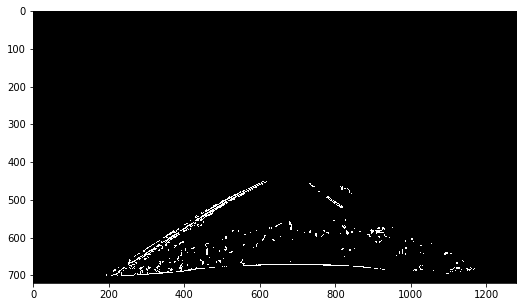

In [106]:

mtx,dist = calibrate()
white_output = 'output_videos/project_video1.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(41,42)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)